In [1]:
!pip install --quiet --upgrade langchain langchain-community langgraph langchain_openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires request

In [95]:
from langchain.chat_models.base import init_chat_model



llm = init_chat_model(
    model="openai/gpt-oss-20b:free",
    model_provider="openai",
    base_url="https://openrouter.ai/api/v1",
    api_key = "YOUR_OPENROUTER_APIt",
    temperature=0.1,
    max_tokens=4096,
    model_kwargs={"top_p" : 0.95}
    )


/tmp/ipython-input-2319595913.py:5: UserWarning: Parameters {'top_p'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  llm = init_chat_model(


In [151]:
from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import HumanMessage
from IPython.display import display, Markdown, Image


class CustomState(TypedDict):
    messages: List[BaseMessage]
    retrieved_docs: Optional[List[dict]]
    retrieved_text: Optional[str]
    outline: Optional[str]
    essay: Optional[str]
    cleaned_essay: Optional[str]

PLANNING_PROMPT_TEMPLATE = """
You are an expert content strategist. Produce a focused, high-level essay outline for QUESTION: {query}.
Return 4–7 numbered sections (intro, body sections, conclusion). For each section give a 1-line purpose, 2–4 bullet points of key ideas/evidence, and any short writing notes (tone, examples, sources).
Keep concise and actionable.
"""

ESSAY_PROMPT_TEMPLATE = """
You are an expert content writer. Expand the OUTLINE: {outline} into a coherent essay that follows the structure.
For each section include a clear heading, developed paragraphs (2–4 per section as needed), smooth transitions, and a concise conclusion. Preserve the outline’s intent and ensure clarity, flow, and readability.
"""

GRAMMAR_PROMPT_TEMPLATE = """
You are an expert English editor. Improve ESSAY: {essay} for grammar, punctuation, clarity, and flow while preserving meaning and structure.
Tighten phrasing, fix tense/voice inconsistencies, improve headings if helpful, and keep tone consistent. Return only the edited essay.
"""


def planning_fn(inputs: dict) -> dict:
    query = inputs.get("messages", "")
    print(query)

    prompt = PLANNING_PROMPT_TEMPLATE.format(query=query[0].content)
    outline = llm.invoke(prompt)
    return {"outline": outline}

def essay_fn(inputs: dict) -> dict:
    outline = inputs.get("outline", "")
    prompt = ESSAY_PROMPT_TEMPLATE.format(outline=outline)
    essay = llm.invoke(prompt)
    return {"essay": essay}

def grammar_fn(inputs: dict) -> dict:
    essay = inputs.get("essay", "")
    prompt = GRAMMAR_PROMPT_TEMPLATE.format(essay=essay)
    cleaned = llm.invoke(prompt)
    return {"cleaned_essay": cleaned}

def build_blog_graph() -> StateGraph:
    """
    Build and return the StateGraph.
    NOTE: ToolNode expects an iterable of tools, so wrap each function in a list.
    """
    graph_builder = StateGraph(CustomState)

    graph_builder.add_node("Planning",planning_fn)
    graph_builder.add_node("EssayWriting",essay_fn)
    graph_builder.add_node("GrammarFix",grammar_fn)

    graph_builder.add_edge(START, "Planning")
    graph_builder.add_edge("Planning", "EssayWriting")
    graph_builder.add_edge("EssayWriting", "GrammarFix")
    graph_builder.add_edge("GrammarFix", END)

    graph = graph_builder.compile()
    return graph



graph = build_blog_graph()



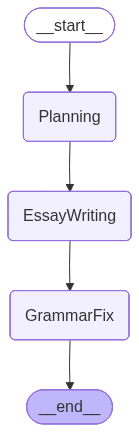

In [152]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [153]:
input_message = [HumanMessage(content="What is Prompt Engineering?")]
result = graph.invoke({"messages": input_message})



[HumanMessage(content='What is Prompt Engineering?', additional_kwargs={}, response_metadata={})]


In [154]:
cleaned_essay = result["cleaned_essay"].content

display(Markdown(cleaned_essay))

**What Is Prompt Engineering?**  
*An essay that demystifies the art and science of crafting the perfect instruction for large‑language models (LLMs).*

---

## 1. Introduction

Imagine telling a machine exactly what you want in a single sentence and having it deliver a polished report, a creative story, or a data‑driven insight in seconds. That sentence is the **prompt**—the bridge between human intent and the vast knowledge stored inside an LLM. In today’s AI‑first world, prompt engineering has become the new “coding” skill that unlocks the full potential of models like GPT‑4, Claude, and Llama‑2.

A recent Gartner report (2024) found that **68 % of enterprises** now rely on LLMs for at least one core business function, and the demand for high‑quality prompts is outpacing the supply of skilled practitioners. This surge is driven by the need to extract actionable insights from unstructured data, automate content creation, and build conversational agents that feel genuinely human.

This essay walks you through the fundamentals of prompt engineering, the techniques that turn a good prompt into a great one, real‑world applications across industries, and the challenges that still loom on the horizon. By the end, you’ll have a clear roadmap for mastering prompt engineering and a call to action that invites you to experiment right away.

---

## 2. Fundamentals of Prompt Engineering

### 2.1 Core Vocabulary

- **Prompt** – The text (or multimodal input) you feed to an LLM.  
- **Context window** – The maximum number of tokens the model can consider at once (e.g., GPT‑4’s 8 k or 32 k tokens).  
- **Token** – The smallest unit of text the model processes; roughly four characters in English.  
- **Temperature** – Controls randomness; 0 = deterministic, 1 = creative.  
- **Top‑k / Top‑p** – Sampling strategies that limit the model’s choice to the most probable tokens.

These parameters are the knobs you turn to shape the model’s behavior. Understanding them is the first step toward precision prompting.

### 2.2 The Prompt–Model–Output Triad

```
[Prompt]  →  [LLM]  →  [Output]
   ↑                 ↓
   └───── Context Window ─────┘
```

- **Prompt**: Sets the task, tone, and constraints.  
- **Model**: Interprets the prompt using its internal weights and the context window.  
- **Output**: The generated text, influenced by temperature, top‑k, and other sampling settings.

The diagram shows that the prompt and the model are inseparable; the output is a product of their interaction. Adjusting any element of the triad can dramatically alter the result.

### 2.3 Length vs. Capacity

A prompt that is too short may leave the model guessing the intent, while an overly long prompt can exceed the context window, truncating critical information. For GPT‑4, a 32 k‑token window allows you to embed an entire report and a set of instructions, but you must still be mindful of the token budget. OpenAI’s API documentation provides a handy token counter that helps you stay within limits.

---

## 3. Techniques & Best Practices

### 3.1 Prompt Framing

- **Question**: “What are the key risks in this investment?”  
- **Instruction**: “Summarize the following legal contract in three bullet points.”  
- **Example‑Based**: Provide a short example of the desired format before asking the model to generate new content.

Choosing the right framing aligns the model’s internal “task” with your goal. For instance, an instruction prompt often yields more consistent formatting than a question prompt.

### 3.2 Iterative Refinement

Start broad: “Explain quantum computing.”  
Then narrow: “Explain quantum computing to a high‑school student in 200 words.”  
Follow‑up: “Add a real‑world application example.”

Each iteration hones the model’s focus and reduces ambiguity. This process mirrors human debugging: you test, observe, and adjust.

### 3.3 System vs. User Messages

In chat‑based models, the **system** message sets the overarching persona and rules (“You are a helpful, concise assistant.”). The **user** message contains the task. Separating these layers prevents the model from conflating instructions with content, leading to cleaner outputs.

### 3.4 Managing Bias & Safety

- **Explicit constraints**: “Do not mention any political ideology.”  
- **Safe completion settings**: Enable OpenAI’s safety filters or use a custom moderation endpoint.

The “Prompt Engineering Handbook” (Brown et al., 2023) recommends embedding safety clauses directly into the prompt to reduce hallucinations and bias amplification.

### 3.5 Case Study: Summarizing a Legal Document

**Prompt**

```
System: You are a legal analyst.
User: Summarize the following contract in 150 words, highlighting obligations, deadlines, and penalties.
[Contract text]
```

**Result**  
The model delivers a concise, bullet‑point summary that captures all critical clauses, demonstrating how framing and token budgeting work together.

---

## 4. Applications & Use Cases

### 4.1 Content Creation

**Prompt**

```
Write a 300‑word LinkedIn post announcing our new AI‑powered analytics platform, using a friendly yet professional tone.
```

**Outcome**  
A ready‑to‑publish post that aligns with brand voice, illustrating prompt engineering’s role in marketing.

### 4.2 Data Extraction

**Prompt**

```
Extract the following fields from the attached invoice: Invoice Number, Date, Total Amount, Vendor Name. Return a JSON object.
```

**Outcome**  
Structured data that can be fed directly into ERP systems, showcasing how prompts turn unstructured text into machine‑readable formats.

### 4.3 Decision Support

**Prompt**

```
Given the quarterly sales data, forecast next quarter’s revenue using a linear trend model. Show calculations and assumptions.
```

**Outcome**  
A transparent forecast that includes methodology, useful for finance teams.

### 4.4 Personal Assistants & Chatbots

**Prompt**

```
You are a travel concierge. The user wants a 5‑day itinerary in Kyoto, Japan, focusing on cultural experiences and local cuisine. Suggest daily plans with times and restaurant recommendations.
```

**Outcome**  
A personalized itinerary that feels conversational and context‑aware, demonstrating how persona and context retention are engineered through prompts.

---

## 5. Challenges, Risks, and Future Directions

### 5.1 Prompt Brittleness

Small wording changes can flip the model’s output dramatically. For example, “Explain the benefits of renewable energy” vs. “Explain the benefits of renewable energy for the environment” can yield different emphases. Researchers are developing *prompt robustness* metrics (ACL 2024) to quantify and mitigate this sensitivity.

### 5.2 Scaling Prompt Generation

Large enterprises need thousands of prompts for diverse workflows. Automating prompt generation—using templates, parameter sweeps, or LLM‑driven prompt synthesis—can reduce manual effort. Prompt‑as‑code frameworks (e.g., PromptLayer) allow version control and reuse.

### 5.3 Ethical Concerns

Hallucinations, misinformation, and bias amplification remain significant risks. Prompt engineers must embed safety constraints, monitor outputs, and employ human‑in‑the‑loop reviews, especially in regulated domains like healthcare and finance.

### 5.4 Emerging Tools

- **Visual Prompt Builders**: Drag‑and‑drop interfaces that let non‑technical users assemble prompts.  
- **LLM‑Driven Prompt Optimization**: Models that suggest refinements based on past performance.  
- **Prompt‑as‑Code Repositories**: Git‑style versioning for prompt libraries.

These tools promise to democratize prompt engineering and make it more systematic.

---

## 6. Conclusion & Call to Action

Prompt engineering is no longer a niche skill; it is the linchpin that turns raw LLM power into tangible business value. By mastering the fundamentals, applying proven techniques, and staying aware of the risks, you can unlock new efficiencies, create compelling content, and build smarter assistants.

Start small: pick a routine task—perhaps summarizing a report or drafting a marketing blurb—and experiment with different prompt framings. Document what works, iterate, and share your findings with your team. Resources like the OpenAI Playground, PromptLayer, and community forums are readily available to accelerate your learning curve.

**What problem can you solve today with a single well‑crafted prompt?** The answer may surprise you—and the possibilities are limitless.